<h1> The aim of this project is to build a CNN for imagines classification. We will try to classify the face of a person in Happy or Sad </h1>

<h2> Importing Libraries </h2>

In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid OMM errors by setting GPU memory consuption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

<h2> The Dataset </h2>

Remove dodgy imagines

In [3]:
import cv2
import imghdr

/var/folders/hy/8k3n5m116bj5d9zy449s77lc0000gn/T/ipykernel_7996/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
#os.listdir(data_dir)
files = os.listdir(data_dir)
if '.DS_Store' in files:
    files.remove('.DS_Store')
print(files)

['happy', 'sad']


In [7]:
# Script to remove dodgy images
for image_class in files:
    for image in os.listdir(os.path.join(data_dir, image_class)):
        if image == '.DS_Store':
            continue  # Skip .DS_Store file
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: {}'.format(image_path))

<h2>Load Data</h2>

In [8]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [9]:
import numpy as np 
import matplotlib.pyplot as plt

In [10]:
#creating the dataset composed by our imagines
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [11]:
#convert into a numpy iterator
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x17fcf3ed0>)

In [12]:
batch = data_iterator.next()

#images represented as numpy arrays
batch[0] #images

array([[[[250.       , 255.       , 254.       ],
         [250.       , 255.       , 254.       ],
         [250.       , 255.       , 254.       ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        [[249.375    , 255.       , 253.375    ],
         [249.375    , 255.       , 253.375    ],
         [249.375    , 255.       , 253.375    ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        [[249.       , 255.       , 253.       ],
         [249.       , 255.       , 253.       ],
         [249.       , 255.       , 253.       ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        ...,

        [[250.4292   , 250.4292   , 25

In [13]:
batch[1] #class of the images (labels), happy or sad, 0 or 1

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int32)

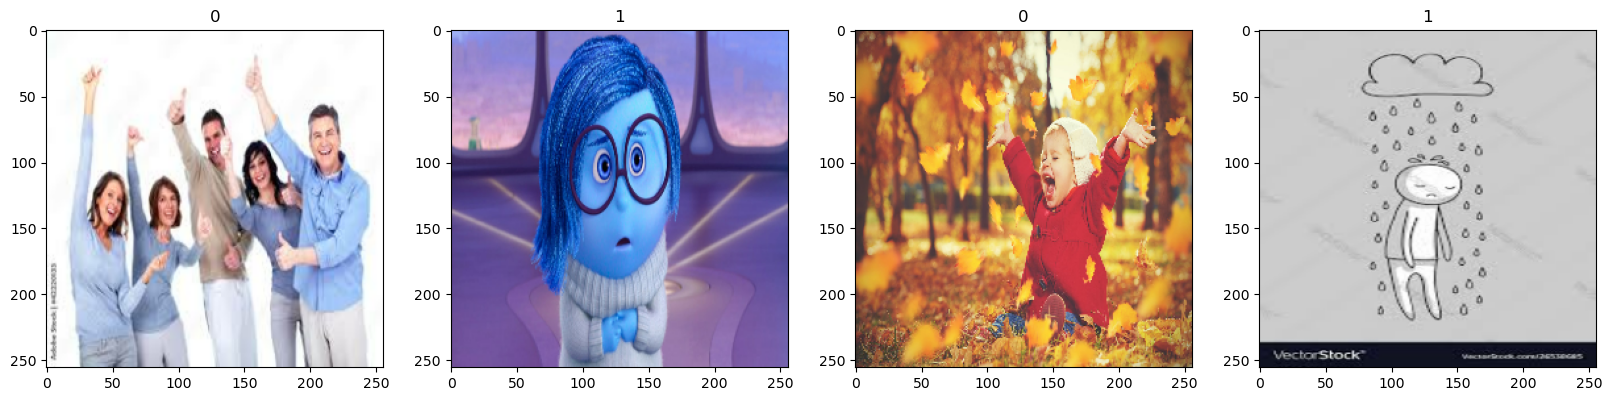

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

we can notice that the values:
- 1 = sad
- 0 = happy

<h2>Preprocessing Data<h2>

- scaling image values to between 0 and 1
- splitting in training and test set

<h3>Scale data</h3>

In [15]:
batch[0].shape

(32, 256, 256, 3)

32 images of shape 256x256 by 3 channels

In [16]:
#scaling image's values
data = data.map(lambda x,y : (x/255, y))

In [17]:
print(data.as_numpy_iterator().next()[0].max(),data.as_numpy_iterator().next()[0].min())

1.0 0.0


<h3>Split Data</h3>

In [53]:
len(data)

10

We have 10 batchs and each batch has 32 images

In [74]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [75]:
#creating the subsets
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

<h2>Deep Learning Model</h2>

- Build a CNN Model
- Train the Model
- Plot Performance
- Evaluate Performance

<h3>Build the Model</h3>

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [77]:
model = Sequential()

In [78]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape= (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/christianbraga/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.compile('adam', loss= tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

<h3>Train the Model</h3>

In [81]:
logdir = 'logs'

In [82]:
tensoboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)

In [83]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensoboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 771ms/step - accuracy: 0.4748 - loss: 1.5972 - val_accuracy: 0.4375 - val_loss: 0.7084
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 711ms/step - accuracy: 0.5545 - loss: 0.6903 - val_accuracy: 0.6094 - val_loss: 0.6203
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 747ms/step - accuracy: 0.5930 - loss: 0.6369 - val_accuracy: 0.7344 - val_loss: 0.5574
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.7310 - loss: 0.5619 - val_accuracy: 0.7344 - val_loss: 0.5451
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.8051 - loss: 0.4853 - val_accuracy: 0.8750 - val_loss: 0.3865
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 722ms/step - accuracy: 0.8470 - loss: 0.4177 - val_accuracy: 0.7031 - val_loss: 0.4712
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step - accuracy: 0.7086 - loss: 0.4945 - val_accuracy: 0.9375 - val_loss: 0.4127
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 749ms/step - accuracy: 0.9188 - loss: 0.3802 - val_accuracy: 0.8594 - val_loss:

<h3>Plot Performances</h3>

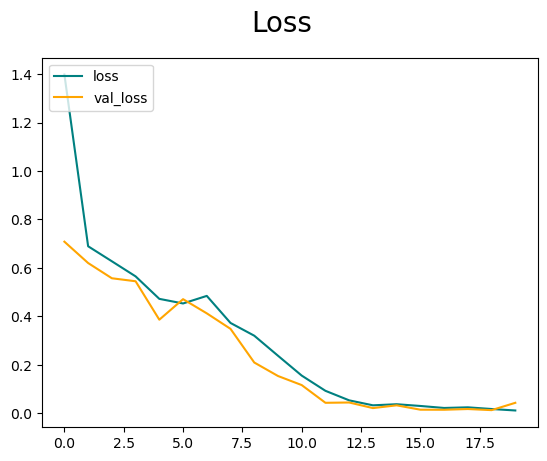

In [84]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

we can see that the validation loss tends to decrease as the training loss, it means that our model is behaving well, we don't have problems of overfitting or underfitting

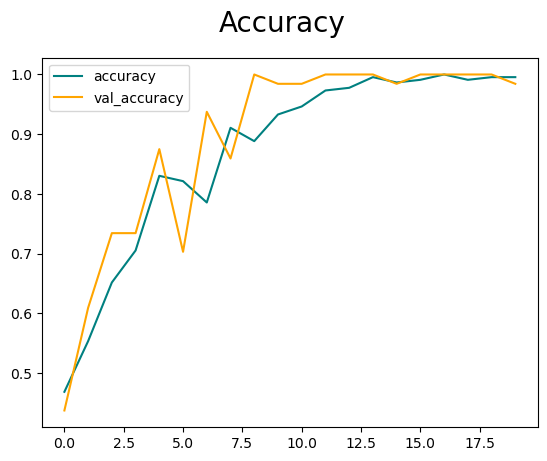

In [85]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

<h3> Evaluate Performance</H3>

In [86]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [87]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [88]:
len(test)

1

In [89]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


2024-08-19 19:12:51.813152: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall:1.0, Accuracy: 1.0


<h3>Test Happy Person</h3>

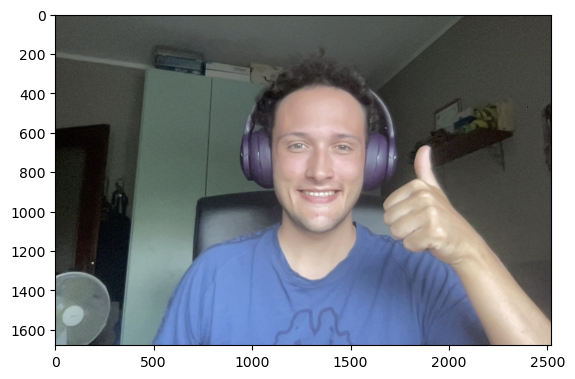

In [91]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

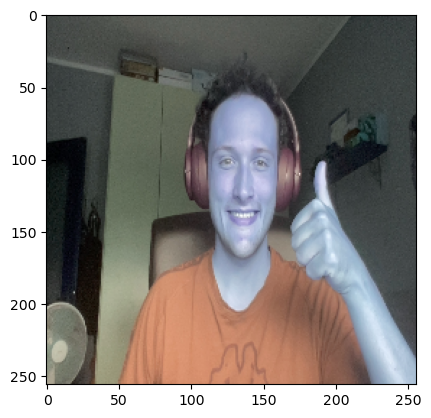

In [93]:
#resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [94]:
np.expand_dims(resize, 0)

array([[[[ 70.311035,  75.311035,  73.311035],
         [ 61.44629 ,  66.44629 ,  64.44629 ],
         [ 70.5625  ,  75.5625  ,  73.5625  ],
         ...,
         [ 53.890625,  61.890625,  61.890625],
         [ 70.49756 ,  75.49756 ,  76.49756 ],
         [ 54.4375  ,  60.4375  ,  59.4375  ]],

        [[ 67.566895,  72.566895,  70.566895],
         [ 76.359375,  81.359375,  79.359375],
         [ 72.93115 ,  77.93115 ,  75.93115 ],
         ...,
         [ 63.709473,  68.70947 ,  69.70947 ],
         [ 64.384766,  69.384766,  70.384766],
         [ 62.765625,  68.765625,  67.765625]],

        [[ 66.89795 ,  72.8042  ,  68.08545 ],
         [ 72.541016,  78.447266,  73.728516],
         [ 72.322754,  77.322754,  75.322754],
         ...,
         [ 62.53174 ,  68.43799 ,  67.62549 ],
         [ 66.50293 ,  71.50293 ,  72.50293 ],
         [ 60.912598,  66.00635 ,  66.81885 ]],

        ...,

        [[167.2666  , 163.2666  , 145.2666  ],
         [170.10303 , 163.10303 , 146.10303 ]

In [95]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.24120484]], dtype=float32)

In this case the model has successively predict, because the score of that image is 0.2405 where 0 is Happy person, as am i in the photo :) 



In [96]:
if yhat > 0.5:
    print('The predicted class is: SAD')
else:
    print('The predicted class is: HAPPY')

The predicted class is: HAPPY


<h3>Test Sad person</h3>

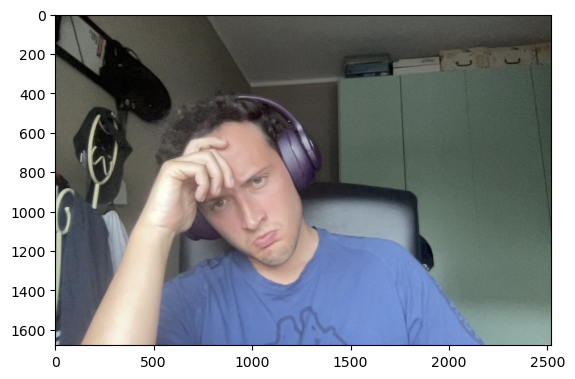

In [97]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

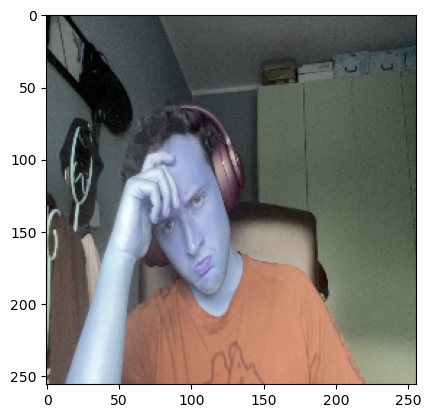

In [98]:
#resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [99]:
yhat2 = model.predict(np.expand_dims(resize/255, 0))
yhat2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.99040145]], dtype=float32)

In [100]:
if yhat2 > 0.5:
    print('The predicted class is: SAD')
else:
    print('The predicted class is: HAPPY')

The predicted class is: SAD


<h2>Save The Model</h2>

In [102]:
from tensorflow.keras.models import load_model

In [103]:
model.save(os.path.join('models','happysadmodel.h5'))

In [104]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [105]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [106]:
if yhatnew > 0.5:
    print('The predicted class is: SAD')
else:
    print('The predicted class is: HAPPY')

The predicted class is: SAD
